In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
df = pd.read_csv('archive/stocks_df.csv', parse_dates=['Date'])
df.head(20000)

,Date,Stock,Open,High,Low,Close,Volume,Change Pct
0,2013-01-02,20MICRONS,80.35,80.55,77.50,77.80,1088880,-3.23
1,2013-01-03,20MICRONS,78.58,79.78,76.00,76.40,590180,-1.80
2,2013-01-04,20MICRONS,76.50,77.25,75.50,75.83,380850,-0.75
3,2013-01-07,20MICRONS,76.88,78.00,74.00,74.90,1144204,-1.23
4,2013-01-08,20MICRONS,74.97,75.97,74.25,75.28,605020,0.51
...,...,...,...,...,...,...,...,...
19995,2015-11-27,A2ZINFRA,27.65,27.65,26.55,27.00,247650,-0.74
19996,2015-11-30,A2ZINFRA,27.40,28.40,27.05,27.45,365465,1.67
19997,2015-12-01,A2ZINFRA,27.90,28.30,27.05,27.50,269388,0.18
19998,2015-12-02,A2ZINFRA,27.70,28.00,26.10,26.45,263195,-3.82


In [20]:
stock_name = "INFY"
stock_df = df[df['Stock'] == stock_name].copy()
stock_df.set_index('Date', inplace=True) 

stock_df.drop('Stock', axis=1, inplace=True)

print(stock_df.isnull().sum())

Open          0
High          0
Low           0
Close         0
Volume        0
Change Pct    0
dtype: int64


In [21]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change Pct']
data = stock_df[features]

train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data) 

In [23]:
def create_sequences(data, target_col_idx, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :]) 
        y.append(data[i+time_steps, target_col_idx])  
    return np.array(X), np.array(y)

time_steps = 60
target_col_idx = 3 

X_train, y_train = create_sequences(train_scaled, target_col_idx, time_steps)
X_test, y_test = create_sequences(test_scaled, target_col_idx, time_steps)

In [24]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Predicts the next-day 'Close' price

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.6687e-04 - val_loss: 0.0014
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.7726e-04 - val_loss: 0.0021
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.9809e-04 - val_loss: 7.9852e-04
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.8027e-04 - val_loss: 0.0013
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.5488e-04 - val_loss: 0.0013
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.4167e-04 - val_loss: 0.0011
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.5820e-04 - val_loss: 5.8726e-04
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3098e-04 - val_loss: 5.6868e-04
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3102e-04 - val_loss: 6.7647e-04
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.8916e-04 - va

In [26]:
predictions = model.predict(X_test)

dummy_array = np.zeros((len(predictions), test_scaled.shape[1]))

dummy_array[:, target_col_idx] = predictions.reshape(-1) 
predictions = scaler.inverse_transform(dummy_array)[:, target_col_idx]

dummy_array[:, target_col_idx] = y_test.reshape(-1) 
y_test_actual = scaler.inverse_transform(dummy_array)[:, target_col_idx]

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


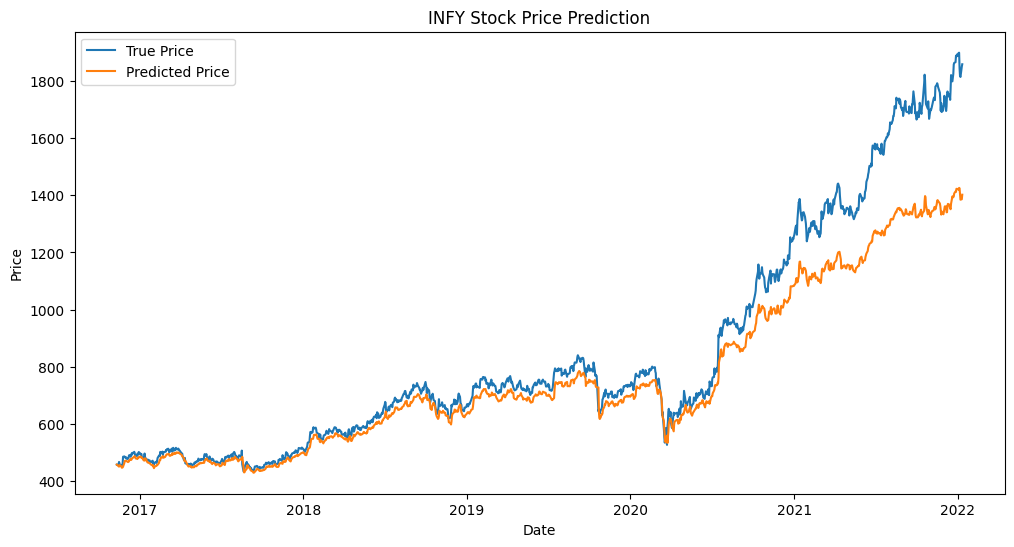

MAE: 87.09
RMSE: 143.47


In [27]:
plt.figure(figsize=(12, 6))
plt.plot(stock_df.index[-len(y_test_actual):], y_test_actual, label='True Price')
plt.plot(stock_df.index[-len(y_test_actual):], predictions, label='Predicted Price')
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")